In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
# from influxdb import InfluxDBClient
import statsmodels.tsa.api as smt
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
pd.set_option("display.max_rows",2000)
pd.set_option("display.max_columns",None)
plt.style.use('Solarize_Light2')

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Importing the Dataset

In [ ]:

# --- country data (country, region, Income Group)
country = pd.read_csv('../input/world-telecommunications-data/Metadata_Country_API_IT.CEL.SETS.P2_DS2_en_csv_v2.csv')

# --- Population data ( Population countrywise)
population = pd.read_csv('../input/world-bank-data-1960-to-2016/country_population.csv')

# --- Fertilty data( Fertility_rate countrywise)
fertility_rate = pd.read_csv('../input/world-bank-data-1960-to-2016/fertility_rate.csv')

# ---  Life_expectancy data(avg Life_expectancy country wise)
life_expectancy = pd.read_csv('../input/world-bank-data-1960-to-2016/life_expectancy.csv')

# --- Migration data(number of immigranted people - number of emmigranted people)
net_migration = pd.read_csv('../input/world-bank-data/Net_migration.csv',engine='python')

# -- Indicator data (Birth_rate, death_rate,age_group_population,gender_population)
world_indicator = pd.read_excel('../input/world-bank-data/World_indicator.xlsx')

# Data Preprocessing

## Filtering the unwanted variables from each dataset

In [ ]:
# -- Country data
country=country[['Country Code','Region','IncomeGroup']]


unwanted_columns=['Indicator Name','Indicator Code','Country Name'] # Unwanted columns for the analysis

# -- Population data
population.drop(unwanted_columns[:2],axis=1,inplace=True)

# --Fertility data
fertility_rate.drop(unwanted_columns,axis=1,inplace=True)

# # --Life_expectancy data
life_expectancy.drop(unwanted_columns,axis=1,inplace=True)

# # --Net_migration data
net_migration.drop(unwanted_columns+['2017','2018','2019'],axis=1,inplace=True) # Analysing the records till year 2016

# # --World_Indicator data
world_indicator.drop(['2017','2018'],axis=1,inplace=True) # Analysing the records till year 2016

## Melting the columns to rows

In [ ]:
# --- Years range for melting the columns to rows
years=[str(i) for i in range(1960,2017)]

# --- Constant columns for melting
variables=['Country Name','Country Code']

In [ ]:
population=pd.melt(population,id_vars=variables,
                      value_vars=years,
                      var_name='Year',
                      value_name='Population')

fertility_rate=pd.melt(fertility_rate,id_vars=variables[1],
                      value_vars=years,
                      var_name='Year',
                      value_name='Fertility_rate')

life_expectancy=pd.melt(life_expectancy,id_vars=variables[1],
                      value_vars=years,
                      var_name='Year',
                      value_name='Life_expectancy')

net_migration=pd.melt(net_migration,id_vars=variables[1],
                      value_vars=years,
                      var_name='Year',
                      value_name='Net_migration')

world_indicator=pd.melt(world_indicator,id_vars=variables+['Series Name'],
                      value_vars=years,
                      var_name='Year',
                      value_name='Values')

### Converting rows to columns using pivot table 

In [ ]:
world_indicator=world_indicator[['Country Code','Year','Series Name','Values']].pivot_table(values='Values',
                                                index=['Country Code','Year'],columns='Series Name',aggfunc=np.sum)

In [ ]:
world_indicator.reset_index(level=['Country Code','Year'],inplace=True)

## Merging the dataset 

In [ ]:
df = pd.merge(country, population, how='left', on='Country Code')
df = pd.merge(df, life_expectancy, how='left', on=['Country Code', 'Year'])
df = pd.merge(df, fertility_rate, how='left', on=['Country Code', 'Year'])
df = pd.merge(df, net_migration, how='left', on=['Country Code', 'Year'])
df = pd.merge(df, world_indicator, how='left', on=['Country Code', 'Year'])

In [ ]:
df.sort_values(by=['Country Name','Year'],inplace=True)
df.reset_index(drop=True,inplace=True)

In [ ]:
df.head()

In [ ]:
# Removing Unwanted Columns Level1:

df.drop(['Country Code'],axis=1,inplace=True)
df.head()

### Adjusting the population accuracy

In [ ]:
val=pd.DataFrame(map(lambda i,j: i if (j=='..' or j!=j) else j if j!=i else i,df['Population'],df['Population, total']))

df.insert(loc=6, column='Total_Population', value=val)

df.drop(['Population','Population, total'],axis=1,inplace=True)

In [ ]:
df.head()

### Checking for characters or words other than alphanumerics

In [ ]:
(df.isnull().sum())+((df=='..').sum())

In [ ]:
# Converting the characters which has '..' 
df[df=='..']=np.nan

In [ ]:
df.head()

In [ ]:
# Removing unwanted rows:
df=df[df['Region'].notna()]
df.head()

### Missing Values & Imputation

In [ ]:
pd.DataFrame(round(df.isnull().sum()/df.shape[0]*100,2),columns=['Missing_values in (%)'])

<b>Removing the columns which has more than 50% of missing values</b>

In [ ]:
bandwidth_50_col=pd.DataFrame(round(df.isnull().sum()/df.shape[0]*100),columns=['Missing_values in (%)'])
col=bandwidth_50_col[bandwidth_50_col['Missing_values in (%)']>50].index
df.drop(col,axis=1,inplace=True)
df.head()

# Imputation Process:</br>

### Target Variable - Total_Population
<p>
For Imputing Total_popualtion we cannot use Traditional use mean/Median Imputation.<br>
We need to use other methods to impute since the records are distinct metric. <br>
    
<b>Method_1 Population_Projection:</b><br>
                 Population projections are simply mathematical formulas that use current populations and<br>
rates of growth to estimate future populations.<br>

               Nt = P e^(r * t)

               Nt  = Number of People at Future time
                P  = Present Population
                e  = base of the natural logarithms (2.71828)
                r  = natrual Increase ( (Birth_rate - Death_rate)/100)
                t  = represents the time period involved
    
By using population Projection formula we can impute the Popualtion.<br>
However, Projections for specific countries and age groups have not been as accurate.<br>In general, projections of future population size tend to be more uncertain, or less accurate:
<ul><ul>
<li>For less developed countries than for more developed countries.
</li>
<li>  
For smaller countries than larger ones.
</li>
<li>
For younger and older age groups than for middle age groups, because incorrect assumptions<br> about fertility and mortality have a greater effect at older and younger ages
    </li>
    <li>
For longer periods (more than two decades) than shorter periods, because of the compounding effects of incorrect assumptions over time.
    </li>
    </ul></ul>

<b>Method_2: Using Population_growth_rate:</b><br>
We can populate new field (Population_growth_rate) using population feature and impute those ,since we have seen that<br> 
the Population for each country is increasing every year.
This is used for Instead of Reverse projection to find the population for the past year from present year.

For populaiton projection or to find the population for future year. we cannot use growth rate, instead we can use 
other varibales to Impute like<br>
  
                  population=present_population + no. of births - no.of deaths + Net_migration 
                  
                      * Net_Migration  = No. of immigrants - No.of emmigrants
          
</p>

In [ ]:

# -- creating new columns (population growth rate)

val=np.where(df['Year']=="1960",0,
    np.where((df['Total_Population'].notna()) & (df['Total_Population'].shift().notna()),
    ((df['Total_Population']-df['Total_Population'].shift())/df['Total_Population'].shift()*100).round(1),np.nan))

df.insert(loc=6, column='Population_growth_rate(%)', value=val)

In [ ]:
df.head()

<b> changing the datatype of the columns </b>

In [ ]:
df['Year']=df['Year'].astype('int')
categorical_col=df.iloc[:,4:].describe(include='O').columns

for i in categorical_col:
    df[i]=df[i].astype('float')

# Imputation 

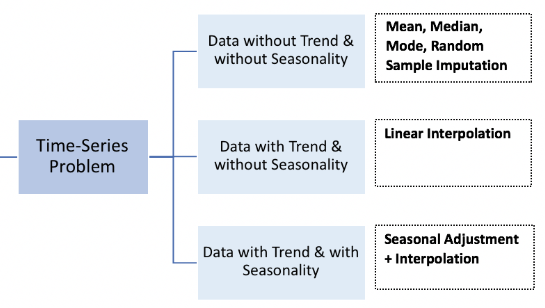

<b>Imputing the Life_expectancy column:</b>

Removing the country which doesn't have data for all years(1960 - 2016)

In [ ]:
dum=pd.unique(df[(df['Life_expectancy'].isna()) & (df['Fertility_rate'].isna()) &
                 (df['Year'].isin([i for i in range(1960,2015)]))]['Country Name'])
df=df[~df['Country Name'].isin(dum)]

In [ ]:
# Country Name with null life Expectany value
null_life_exp=pd.unique(df[df['Life_expectancy'].isna()]['Country Name'])

In [ ]:
plt.plot(pd.unique(df['Year']),df[df['Country Name'].isin(null_life_exp)]['Life_expectancy'])
plt.title("Life_expectancy Before Imputataion")

Since there is a trend we can cubic interpolation for time series data

In [ ]:
index=df[df['Country Name'].isin(null_life_exp)]['Life_expectancy'].index
df.loc[index,'Life_expectancy']=df[df['Country Name'].isin(null_life_exp)]['Life_expectancy'].interpolate(method='cubic')
df.loc[index,'Life_expectancy']=df[df['Country Name'].isin(null_life_exp)]['Life_expectancy'].interpolate(method='linear',limit_direction="both")
plt.plot(pd.unique(df['Year']),df[df['Country Name'].isin(null_life_exp)]['Life_expectancy'])
plt.title("Life_expectancy After Imputataion")

<b>Imputing the  Fertility_rate column:</b>

In [ ]:
null_fertility=pd.unique(df[df['Fertility_rate'].isna()]['Country Name'])

In [ ]:
plt.plot(pd.unique(df['Year']),df[df['Country Name'].isin(null_fertility)]['Fertility_rate'])
plt.title("Fertility_rate Before Imputataion")

In [ ]:
index=df[df['Country Name'].isin(null_fertility)]['Fertility_rate'].index
df.loc[index,'Fertility_rate']=df[df['Country Name'].isin(null_fertility)]['Fertility_rate'].interpolate(method='cubic')

plt.plot(pd.unique(df['Year']),df[df['Country Name'].isin(null_fertility)]['Fertility_rate'])
plt.title("Fertility_rate After Imputataion")

<b>Imputing the  Total_population column:</b>

In [ ]:
null_total_population=pd.unique(df[df['Total_Population'].isna()]['Country Name'])
null_total_population

In [ ]:
plt.plot(pd.unique(df['Year']),df[df['Country Name']==null_total_population[1]]['Total_Population'])
plt.title("Total Population for Kuwait before Imputaion")

For Kuwait since we have before and after data points for interpolation we can use cubic interpolation

In [ ]:
index=df[df['Country Name']==null_total_population[1]]['Total_Population'].index
df.loc[index,'Total_Population']=df[df['Country Name']==null_total_population[1]]['Total_Population'].interpolate(method='cubic')

plt.plot(pd.unique(df['Year']),df[df['Country Name']==null_total_population[1]]['Total_Population'])
plt.title("Total Population for Kuwait After Imputaion")


----------------------------------------------------------<br>
For Eritrea we have missing values in end segment so interpolation doesn't work<br>
We can use population growth rate column to impute the end segment values since there is positive trend

In [ ]:
plt.plot(pd.unique(df['Year']),df[df['Country Name']==null_total_population[0]]['Total_Population'])
plt.title("Total Population for Eritrea before Imputaion")

In [ ]:
df[['Population_growth_rate(%)']]=df[['Population_growth_rate(%)']].fillna(method='ffill')

Since there is a positive trend in the Popualtion  we are imputing the population growth rate to Imputation.

In [ ]:
df['dummy']=df['Total_Population']
while(len(df[df['dummy'].isna()])>0):
    val=np.where((df['dummy'].isna()),
        df['dummy'].shift(periods=1)*(1+(df['Population_growth_rate(%)']/100)),df['dummy'])
    df['dummy']=val
df['Total_Population']=df['dummy']
df.drop('dummy',axis=1,inplace=True)

In [ ]:
plt.plot(pd.unique(df['Year']),df[df['Country Name']==null_total_population[0]]['Total_Population'])
plt.title("Total Population for Eritrea After Imputaion")

In [ ]:
df.isnull().sum()

<b>Renaming the column name for convenience</b>

In [ ]:
df=df.rename(columns={'Birth rate, crude (per 1,000 people)':'Birth_rate','Death rate, crude (per 1,000 people)':'Death_rate',
                  'GDP growth (annual %)':'GDP_growth'})

In [ ]:
df.head()

## Feature Engineering :

<b> Converting crude birth rate of factor 1000 to distinct value <b>

In [ ]:
val=np.round(df['Total_Population']*df['Birth_rate']/1000)
df.insert(loc=8, column='Total_births', value=val)
df.head()

<b> Converting crude Death rate of factor 1000 to distinct value <b>

In [ ]:
val=np.round(df['Total_Population']*df['Death_rate']/1000)
df.insert(loc=9, column='Total_deaths', value=val)
df.head()

<b> creating a new column Net Migration:</b><br><br>
Total_population diff from previous year= Natural_Increase + Net Migration <br><br>
        Natural_increase= total_births - total_deaths<br>
<br>
Net Migration = Total_population diff from previous year - Natural_Increase<br>

In [ ]:
Natural_Increase= df['Total_births']-df['Total_deaths']
Total_pop_diff_prev_year=df.groupby(['Country Name'])['Total_Population'].diff().fillna(0)
Net_Migration=Total_pop_diff_prev_year-Natural_Increase
df.insert(loc=10, column='Net_Migration', value=Net_Migration)
df.loc[df['Year'] ==1960, ['Net_Migration']] = 0

In [ ]:
df.head()

In [ ]:
df.info()

## Feature Selection:

<b> Feature Selection for india </b>

In [ ]:
columns=['Year','Life_expectancy','Total_Population','Fertility_rate']

In [ ]:
df1=df[df['Country Name']=='India'][columns]

In [ ]:
for i in df1.columns[1:]:
    acf = smt.graphics.plot_acf(df1[i], lags=40 , alpha=0.05,title=i)
    acf.show()

Statestic test for auto correlation using dutbin_watson test

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(df1.iloc[:,1:])

In [ ]:
for col,val in zip(df1.columns[1:],out):
    print(col,' : ',round(val,4))

 All Values are less than 2 so we can say all columns are positive correlated

# VAC- Vector Auto Regression

### Testing Causation using Granger’s Causality Test

<p>
Null Hypothesis      : Variable X does not Cause Varible Y <br>
Alternate HYpothesis : Varibel X causes Variable Y
 </p>

In [ ]:
fig, axs = plt.subplots(3)
axs[0].plot(df1['Year'],df1['Life_expectancy'])
axs[1].plot(df1['Year'],df1['Fertility_rate'])
axs[2].plot(df1['Year'],df1['Total_Population'])


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df2 = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df2.columns:
        for r in df2.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df2.loc[r, c] = min_p_value
    df2.columns = [var + '_x' for var in variables]
    df2.index = [var + '_y' for var in variables]
    return df2

grangers_causation_matrix(df1, variables = df1.columns) 

### Train Test Split

In [ ]:
column=['Life_expectancy','Total_Population','Fertility_rate']

In [ ]:
X_train=df1[df1['Year']<2016][column]
y_train=df1[df1['Year']<2016]['Year']
X_test=df1[df1['Year']>=2016][column]
y_test=df1[df1['Year']>=2016]['Year']

### Checking whether the columns are stationary or not

Null Hypothesis: Data has unit root. Non Stationary<br>
Alternate Hypothesis: Data does not have unit root. Stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [ ]:
# ADF Test on each column
for name, column in X_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

Stationary means there is a no trend over the years or the mean and median does not change over the years
But the all columns are non stationary except Fertility rate Which means fertiltiy rate is stable throught out the years

### Changing non stationary to stationary

In [ ]:
# 1st difference
X_train_differenced = X_train.diff().dropna()

In [ ]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in X_train_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

In [ ]:
# second Differnce

X_train_differenced = X_train_differenced.diff().dropna()

In [ ]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in X_train_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

In [ ]:
# Third Difference

X_train_differenced = X_train_differenced.diff().dropna()

In [ ]:
# ADF Test on each column of 3rd Differences Dataframe
for name, column in X_train_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

So after the third differnce all columns have become stationary

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
model = VAR(X_train_differenced)
x = model.select_order(maxlags=12)
x.summary()

Lag 3 is best suited for VAR because there is fluctuation in those lags

In [ ]:
model = VAR(X_train_differenced)
results = model.fit(maxlags=15, ic='aic')
results.summary()

In [ ]:
results.plot_forecast(20)

In [ ]:
# forecasting
nobs=50
pred = results.forecast(results.y, steps=nobs)
df_forecast = pd.DataFrame(pred, index=X_train.index[-nobs:], columns=X_train.columns + '_1d')
df_forecast.tail()
# inverting transformation
def invert_transformation(df_train, df_forecast, second_diff=True):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
# show inverted results in a dataframe
df_results = invert_transformation(X_train, df_forecast, second_diff=True)        
# df_results.loc[:, ['Total_Population','Life_expectancy','Fertility_rate']]

In [ ]:
Final_forecast=df_results.copy()

In [ ]:
val=[i for i in range(2016,2016+len(Final_forecast))]

Final_forecast.insert(loc=0, column='Year', value=val)

In [ ]:
Final_forecast.drop(['Life_expectancy_1d','Total_Population_1d','Fertility_rate_1d'],axis=1,inplace=True)

In [ ]:
Final_forecast.head(10)

## Actual vs Forecast for year 2016 in india

In [ ]:
X_test.head()

In [ ]:
print('The percentage of differnce between Actual and Forecasted result for India:')
print("Life_expectancy  :",np.round((Final_forecast.iloc[0,1]-X_test.iloc[0,0])/X_test.iloc[0,0]*100,3),'%')
print("Total_Population :",np.round((Final_forecast.iloc[0,2]-X_test.iloc[0,1])/X_test.iloc[0,1]*100,3),'%')
print("Fertility_rate   :",np.round((Final_forecast.iloc[0,3]-X_test.iloc[0,2])/X_test.iloc[0,2]*100,3),'%')

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE 
    return({'mape':mape,'rmse':rmse})

In [ ]:
print(forecast_accuracy(Final_forecast.iloc[0,2],X_test.iloc[0,1]))

In [ ]:
df_final_actual=df[df['Country Name']=='India'][['Year','Total_Population']]
df_final_actual['Legend']='Actual'
df_final_forecast=pd.DataFrame(Final_forecast[['Year','Total_Population_forecast']])
df_final_forecast=df_final_forecast.rename(columns={'Total_Population_forecast':'Total_Population'})
df_final_forecast['Legend']='Forecast'
df_final=pd.concat([df_final_actual,df_final_forecast],ignore_index=True)


plt.figure(figsize=(9,7))
sns.lineplot(x='Year',y='Total_Population',data=df_final,hue='Legend',style='Legend',dashes=True)
plt.title('Forecast vs Actuals population for India')
plt.legend(loc='upper left', fontsize=18,title=None)
plt.show()

## Population Prediction for Israel

In [ ]:
df2=df[df['Country Name']=='Israel'][columns]
df2.head()
column=['Life_expectancy','Total_Population','Fertility_rate']

In [ ]:
X_train=df2[df2['Year']<2016][column]
y_train=df2[df2['Year']<2016]['Year']
X_test=df2[df2['Year']>=2016][column]
y_test=df2[df2['Year']>=2016]['Year']

## Stationarity Test

In [ ]:
# ADF Test on each column
for name, column in X_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

### Changing Non stationary to stationary

In [ ]:
# 1st difference
X_train_differenced = X_train.diff().dropna()

In [ ]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in X_train_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
model = VAR(X_train_differenced)
x = model.select_order(maxlags=12)
x.summary()

In [ ]:
model = VAR(X_train_differenced)
results = model.fit(maxlags=17, ic='aic')
results.summary()

In [ ]:
# forecasting
nobs=50
pred = results.forecast(results.y, steps=nobs)
df_forecast = pd.DataFrame(pred, index=X_train.index[-nobs:], columns=X_train.columns + '_1d')
df_forecast.tail()
# inverting transformation
def invert_transformation(df_train, df_forecast, second_diff=True):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
# show inverted results in a dataframe
df_results = invert_transformation(X_train, df_forecast, second_diff=True)        
# df_results.loc[:, ['Total_Population','Life_expectancy','Fertility_rate']]

In [ ]:
 
Final_forecast=df_results.copy()
 
val=[i for i in range(2016,2016+len(Final_forecast))]

Final_forecast.insert(loc=0, column='Year', value=val)

Final_forecast.drop(['Life_expectancy_1d','Total_Population_1d','Fertility_rate_1d'],axis=1,inplace=True)

Final_forecast.head()

In [ ]:
print('The percentage of differnce between Actual and Forecasted result for Israel:')
# print("Life_expectancy  :",np.round((Final_forecast.iloc[0,1]-X_test.iloc[0,0])/X_test.iloc[0,0]*100,3),'%')
print("Total_Population :",np.round((Final_forecast.iloc[0,2]-X_test.iloc[0,1])/X_test.iloc[0,1]*100,3),'%')
# print("Fertility_rate   :",np.round((Final_forecast.iloc[0,3]-X_test.iloc[0,2])/X_test.iloc[0,2]*100,3),'%')

In [ ]:
df_final_actual=df[df['Country Name']=='Israel'][['Year','Total_Population']]
df_final_actual['Legend']='Actual'
df_final_forecast=pd.DataFrame(Final_forecast[['Year','Total_Population_forecast']])
df_final_forecast=df_final_forecast.rename(columns={'Total_Population_forecast':'Total_Population'})
df_final_forecast['Legend']='Forecast'
df_final=pd.concat([df_final_actual,df_final_forecast],ignore_index=True)


plt.figure(figsize=(9,7))
sns.lineplot(x='Year',y='Total_Population',data=df_final,hue='Legend',style='Legend',dashes=True)
plt.title('Forecast vs Actuals population for Israel')
plt.legend(loc='upper left', fontsize=18,title=None)
plt.show()

## Population Prediction for Tanzania

In [ ]:
df3=df[df['Country Name']=='Tanzania'][columns]
df3.head()
column=['Life_expectancy','Total_Population','Fertility_rate']

In [ ]:
X_train=df3[df3['Year']<2016][column]
y_train=df3[df3['Year']<2016]['Year']
X_test=df3[df3['Year']>=2016][column]
y_test=df3[df3['Year']>=2016]['Year']

### Stationarity Test

In [ ]:
# ADF Test on each column
for name, column in X_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

<b> Changing Non stationary to Stationary

In [ ]:
# 1st difference
X_train_differenced = X_train.diff().dropna()

In [ ]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in X_train_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

In [ ]:
# second Differnce

X_train_differenced = X_train_differenced.diff().dropna()

In [ ]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in X_train_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

In [ ]:
# third Differnce

X_train_differenced = X_train_differenced.diff().dropna()

In [ ]:
# ADF Test on each column of 3rd Differences Dataframe
for name, column in X_train_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
model = VAR(X_train_differenced)
x = model.select_order(maxlags=12)
x.summary()

In [ ]:
model = VAR(X_train_differenced)
results = model.fit(maxlags=15, ic='aic')
results.summary()

In [ ]:
# forecasting
nobs=50
pred = results.forecast(results.y, steps=nobs)
df_forecast = pd.DataFrame(pred, index=X_train.index[-nobs:], columns=X_train.columns + '_1d')
df_forecast.tail()
# inverting transformation
def invert_transformation(df_train, df_forecast, second_diff=True):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
# show inverted results in a dataframe
df_results = invert_transformation(X_train, df_forecast, second_diff=True)        
# df_results.loc[:, ['Total_Population','Life_expectancy','Fertility_rate']]

In [ ]:
 
Final_forecast=df_results.copy()
 
val=[i for i in range(2016,2016+len(Final_forecast))]

Final_forecast.insert(loc=0, column='Year', value=val)

Final_forecast.drop(['Life_expectancy_1d','Total_Population_1d','Fertility_rate_1d'],axis=1,inplace=True)

Final_forecast.head()

In [ ]:
print('The percentage of differnce between Actual and Forecasted result for Tanzania:')
# print("Life_expectancy  :",np.round((Final_forecast.iloc[0,1]-X_test.iloc[0,0])/X_test.iloc[0,0]*100,3),'%')
print("Total_Population :",np.round((Final_forecast.iloc[0,2]-X_test.iloc[0,1])/X_test.iloc[0,1]*100,3),'%')
# print("Fertility_rate   :",np.round((Final_forecast.iloc[0,3]-X_test.iloc[0,2])/X_test.iloc[0,2]*100,3),'%')

In [ ]:
df_final_actual=df[df['Country Name']=='Tanzania'][['Year','Total_Population']]
df_final_actual['Legend']='Actual'
df_final_forecast=pd.DataFrame(Final_forecast[['Year','Total_Population_forecast']])
df_final_forecast=df_final_forecast.rename(columns={'Total_Population_forecast':'Total_Population'})
df_final_forecast['Legend']='Forecast'
df_final=pd.concat([df_final_actual,df_final_forecast],ignore_index=True)


plt.figure(figsize=(9,7))
sns.lineplot(x='Year',y='Total_Population',data=df_final,hue='Legend',style='Legend',dashes=True)
plt.title('Forecast vs Actuals population for Tanzania')
plt.legend(loc='upper left', fontsize=18,title=None)
plt.show()

<b>

<b>

<b>

#                       ARIMA Model

In [ ]:
data=df[df['Country Name']=='India'][['Year','Total_Population']].reset_index(drop=True)
data=data.set_index('Year')
train=data.iloc[:-1,:]
test=data.iloc[-1:,:]

## Population Prediction for India

### Checking Stationarity and Finding the value for hyperparameter d

Number of differencing required for changing non staionarity to stationary

In [ ]:
pip install pmdarima

In [ ]:
from pmdarima.arima.utils import ndiffs

## Adf Test
print('ADF: ',ndiffs(train['Total_Population'], test='adf'))

# PP test:
print('PP',ndiffs(train['Total_Population'], test='pp'))

# KPSS test
print('KPSS',ndiffs(train['Total_Population'], test='kpss'))

So the number of differencing need is d=2

### Finding the Hyperparameter value P ( Number of lags)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train['Total_Population'], start_p=1, start_q=1,
                      test='pp',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

In [ ]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf
ind=[i for i in range(2016,2031)]

# Make as pandas series
fc_series = pd.Series(fc, index=ind)
lower_series = pd.Series(conf[:, 0], index=ind)
upper_series = pd.Series(conf[:, 1], index=ind)

# Plot
plt.figure(figsize=(7,5), dpi=100)
plt.plot(train, label='training')
# plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecasted population for India with 95% confidence band')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
fitted.summary()

In [ ]:
print('The percentage of differnce between Actual and Forecasted result for India:')
val=np.round((fc_series.iloc[0]-test.iloc[0])/test.iloc[0]*100,3)
print("Total_Population :",val.loc['Total_Population'],'%')

In [ ]:
np.round(fc_series.iloc[0])

In [ ]:
print(forecast_accuracy(fc_series.iloc[0],test.iloc[0]))

## Population Prediction for Israel

In [ ]:
data=df[df['Country Name']=='Israel'][['Year','Total_Population']].reset_index(drop=True)
data=data.set_index('Year')
train=data.iloc[:-1,:]
test=data.iloc[-1:,:]

In [ ]:
from pmdarima.arima.utils import ndiffs

## Adf Test
print('ADF: ',ndiffs(train['Total_Population'], test='adf'))

# PP test:
print('PP',ndiffs(train['Total_Population'], test='pp'))

# KPSS test
print('KPSS',ndiffs(train['Total_Population'], test='kpss'))

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train['Total_Population'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

In [ ]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 2, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf
ind=[i for i in range(2016,2031)]

# Make as pandas series
fc_series = pd.Series(fc, index=ind)
lower_series = pd.Series(conf[:, 0], index=ind)
upper_series = pd.Series(conf[:, 1], index=ind)

# Plot
plt.figure(figsize=(7,5), dpi=100)
plt.plot(train, label='training')
# plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecasted population for Israel with 95% confidence band')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
fitted.summary()

In [ ]:
print('The percentage of differnce between Actual and Forecasted result for Israel:')
val=np.round((fc_series.iloc[0]-test.iloc[0])/test.iloc[0]*100,3)
print("Total_Population :",val.loc['Total_Population'],'%')

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    accuracy = 100-np.mean(np.abs(forecast - actual)/np.abs(actual))
    return round(accuracy,5)

print("Accuracy level:",forecast_accuracy(fc_series.iloc[0], test.iloc[0]))

## Population Prediction for Tanzania

In [ ]:
data=df[df['Country Name']=='Tanzania'][['Year','Total_Population']].reset_index(drop=True)
data=data.set_index('Year')
train=data.iloc[:-1,:]
test=data.iloc[-1:,:]

In [ ]:
from pmdarima.arima.utils import ndiffs

## Adf Test
print('ADF: ',ndiffs(train['Total_Population'], test='adf'))

# PP test:
print('PP',ndiffs(train['Total_Population'], test='pp'))

# KPSS test
print('KPSS',ndiffs(train['Total_Population'], test='kpss'))

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train['Total_Population'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

In [ ]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(2, 2, 3))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf
ind=[i for i in range(2016,2031)]

# Make as pandas series
fc_series = pd.Series(fc, index=ind)
lower_series = pd.Series(conf[:, 0], index=ind)
upper_series = pd.Series(conf[:, 1], index=ind)

# Plot
plt.figure(figsize=(7,5), dpi=100)
plt.plot(train, label='training')
# plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecasted population for Tanzania with 95% confidence band')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
fitted.summary()

In [ ]:
print('The percentage of differnce between Actual and Forecasted result for Tanzania:')
val=np.round((fc_series.iloc[0]-test.iloc[0])/test.iloc[0]*100,3)
print("Total_Population :",val.loc['Total_Population'],'%')

In [ ]:
# Accuracy metrics

print("Accuracy level:",forecast_accuracy(fc_series.iloc[0], test.iloc[0]))

<br><br>
# Exponential Smoothing

<b>Simple Exponential Smoothing</b>
>When to use?<br>
   Few data points, Irregular data, No seasonality or trend.<br><br>
   
   
<b>Holt’s Linear Smoothing</b>
>When to use?<br>
Trend in data, No seasonality.<br><br>


<b>Holt’s Damped Trend</b>
>When to use?<br>
Data has a trend. Use the multiplicative version, unless the data has been logged before. In this case, use the additive version

## Population Prediction for India

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt


data=df[df['Country Name']=='India'][['Year','Total_Population']].reset_index(drop=True)
data=data.set_index('Year')
train=data.iloc[:-1,:]
test=data.iloc[-1:,:]

In [ ]:
model = Holt(np.asarray(train['Total_Population']))


fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(15)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(15)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(15)


In [ ]:
fit1.summary()

In [ ]:
fit2.summary()

In [ ]:
fit3.summary()

<b> Fit2 is better because it has lowest AIC score

In [ ]:

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ind=[i for i in range(2016,2031)]
# ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
#     ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(ind, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing ( India )")
plt.legend();

In [ ]:
print('The percentage of differnce between Actual and Forecasted result for India:')
f1=np.round((pred1[0]-test.iloc[0])/test.iloc[0]*100,3)
f2=np.round((pred2[0]-test.iloc[0])/test.iloc[0]*100,3)
f3=np.round((pred3[0]-test.iloc[0])/test.iloc[0]*100,3)
print("Total_Population for model with alpha= 0.3 and beta=0.05: ",f1.loc['Total_Population'],'%')
print("Total_Population for model with alpha= 0.9 and beta=0.57: ",f2.loc['Total_Population'],'%')
print("Total_Population for model with alpha= 0.3 and beta=0.2 : ",f3.loc['Total_Population'],'%')

In [ ]:
print(forecast_accuracy(pred2[0],test.iloc[0]))

## Population Prediction for Israel

In [ ]:
data=df[df['Country Name']=='Israel'][['Year','Total_Population']].reset_index(drop=True)
data=data.set_index('Year')
train=data.iloc[:-1,:]
test=data.iloc[-1:,:]

In [ ]:
model = Holt(np.asarray(train['Total_Population']))


fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(15)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(15)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(15)


In [ ]:
fit1.summary()

In [ ]:
fit2.summary()

In [ ]:
fit3.summary()

In [ ]:

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ind=[i for i in range(2016,2031)]
# ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
#     ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(ind, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing ( Israel )")
plt.legend();

In [ ]:
print('The percentage of differnce between Actual and Forecasted result for Israel:')
f1=np.round((pred1[0]-test.iloc[0])/test.iloc[0]*100,3)
f2=np.round((pred2[0]-test.iloc[0])/test.iloc[0]*100,3)
f3=np.round((pred3[0]-test.iloc[0])/test.iloc[0]*100,3)
print("Total_Population for model with alpha= 0.3 and beta=0.05: ",f1.loc['Total_Population'],'%')
print("Total_Population for model with alpha= 0.9 and beta=0.57: ",f2.loc['Total_Population'],'%')
print("Total_Population for model with alpha= 0.3 and beta=0.2 : ",f3.loc['Total_Population'],'%')

In [ ]:
print(forecast_accuracy(pred2[0],test.iloc[0]))

## Population Prediction for Tanzania

In [ ]:
data=df[df['Country Name']=='Tanzania'][['Year','Total_Population']].reset_index(drop=True)
data=data.set_index('Year')
train=data.iloc[:-1,:]
test=data.iloc[-1:,:]

In [ ]:
model = Holt(np.asarray(train['Total_Population']))


fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(15)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(15)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(15)


In [ ]:
fit1.summary()

In [ ]:
fit2.summary()

In [ ]:
fit3.summary()

In [ ]:

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ind=[i for i in range(2016,2031)]
# ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
#     ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(ind, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing ( Tanzania )")
plt.legend();

In [ ]:
print('The percentage of differnce between Actual and Forecasted result for Tanzania:')
f1=np.round((pred1[0]-test.iloc[0])/test.iloc[0]*100,3)
f2=np.round((pred2[0]-test.iloc[0])/test.iloc[0]*100,3)
f3=np.round((pred3[0]-test.iloc[0])/test.iloc[0]*100,3)
print("Total_Population for model with alpha= 0.3 and beta=0.05: ",f1.loc['Total_Population'],'%')
print("Total_Population for model with alpha= 0.9 and beta=0.57: ",f2.loc['Total_Population'],'%')
print("Total_Population for model with alpha= 0.3 and beta=0.2 : ",f3.loc['Total_Population'],'%')

In [ ]:
print(forecast_accuracy(pred2[0],test.iloc[0]))